# Preparing Dataset to get loaded for use into Colab

In [ ]:
#Mounting Drive into Google Colab to fetch the dataset from drive 

from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
#Installing patool for unraring rar dataset file

!pip install patool

     |████████████████████████████████| 81kB 2.3MB/s 


In [ ]:
#Importing patool and extracting the archive

import patoolib
patoolib.extract_archive("/content/gdrive/My Drive/RPS_TEMP.rar", outdir="/tmp")

patool: Extracting /content/gdrive/My Drive/RPS_TEMP.rar ...
patool: running /usr/bin/unrar x -- "/content/gdrive/My Drive/RPS_TEMP.rar"
patool:     with cwd='/tmp'
patool: ... /content/gdrive/My Drive/RPS_TEMP.rar extracted to `/tmp'.


'/tmp'

# Showing some important information from the dataset
Dataset consists of 9691 images divided into Training and Validation sets by a  split of approx 72-28

Training Images = 7038
Validation Images = 2653

The dataset comprises of images collected and merged into 1 from 3 sources

Links:-

1. https://github.com/alessandro-giusti/rock-paper-scissors
2. https://www.kaggle.com/drgfreeman/rockpaperscissors
3. http://www.laurencemoroney.com/rock-paper-scissors-dataset/



In [ ]:
#Importing some basic modules and Tensorflow

import os
import numpy as np
import pandas as pd
import tensorflow as tf

In [ ]:
#ImageDataGenerator is for Data Augmentation

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
#matplotlib for plotting graphs and showing images

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

**Printing the number of training and validation examples of each category present in the dataset**

In [ ]:
rock_train = os.path.join('/tmp/rps-train/rock')
paper_train = os.path.join('/tmp/rps-train/paper')
scissors_train = os.path.join('/tmp/rps-train/scissors')

print("Number of training images for rock = "+str(len(os.listdir(rock_train))))
print("Number of training images for paper = "+str(len(os.listdir(paper_train))))
print("Number of training images for scissors = "+str(len(os.listdir(scissors_train))))


Number of training images for rock = 2353
Number of training images for paper = 2294
Number of training images for scissors = 2391


In [ ]:
rock_valid = os.path.join('/tmp/rps-test/rock')
paper_valid = os.path.join('/tmp/rps-test/paper')
scissors_valid = os.path.join('/tmp/rps-test/scissors')

print("Number of validation images for rock = "+str(len(os.listdir(rock_valid))))
print("Number of validation images for paper = "+str(len(os.listdir(paper_valid))))
print("Number of validation images for scissors = "+str(len(os.listdir(scissors_valid))))

Number of validation images for rock = 881
Number of validation images for paper = 867
Number of validation images for scissors = 905


**Showing some images from the dataset**

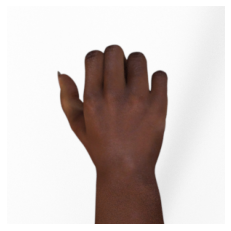

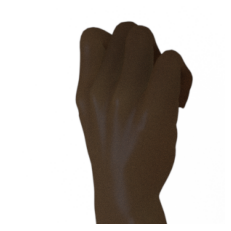

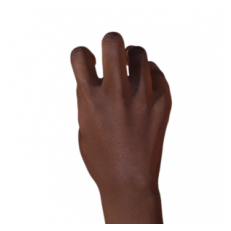

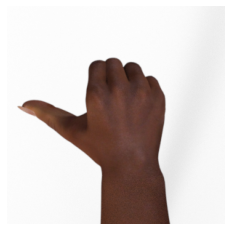

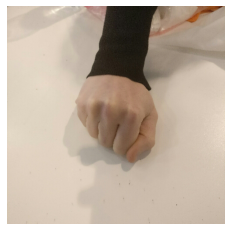

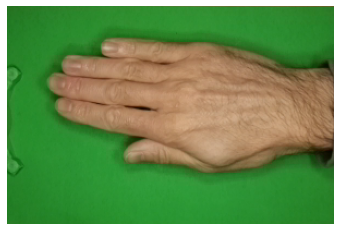

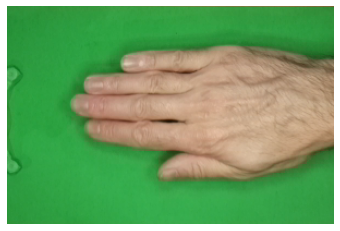

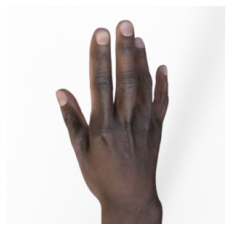

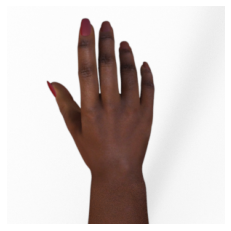

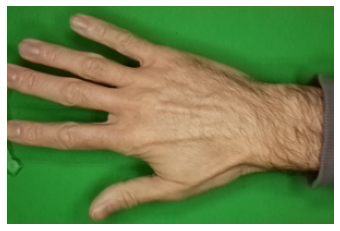

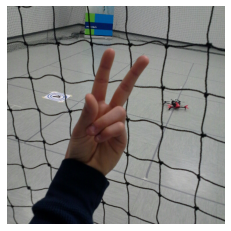

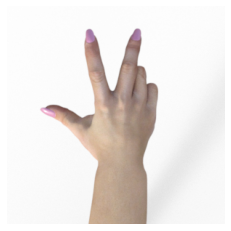

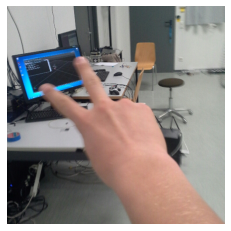

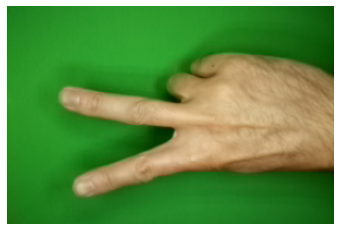

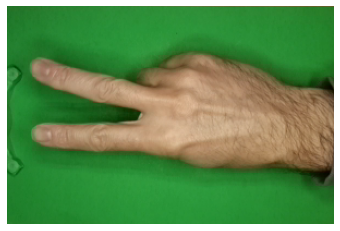

In [ ]:
#Running this cell will result in printing of 5 images each from the 3 categories
rock_imgs = os.listdir(rock_train)
paper_imgs = os.listdir(paper_train)
scissors_imgs = os.listdir(scissors_train)

rock_next = [os.path.join(rock_train,filename)
                for filename in rock_imgs[0:5]]

paper_next = [os.path.join(paper_train, filename)
                 for filename in paper_imgs[0:5]]

scissors_next = [os.path.join(scissors_train,filename)
                    for filename in scissors_imgs[0:5]]

for i, filepath in enumerate(rock_next+paper_next+scissors_next):
    img = mpimg.imread(filepath)
    plt.imshow(img)
    plt.axis('Off')
    plt.show()

# Data Augmentation

*   It is a technique to increase the diversity of your training set by applying random (but realistic) transformations such as image rotation, cropping, image flips etc.
*   Luckily, we have Tensorflow which enables us to do augment the data while the model is getting trained.
*   All happens without any effort from our side, and each file in the training set gets augmented.





In [ ]:
Training_dir = '/tmp/rps-train'
Validation_dir = '/tmp/rps-test'

training_datagen = ImageDataGenerator(rescale = 1./255.0,                       #Each pixel value is divided by 255(maximum value of any pixel)
                                     rotation_range = 90,                       #Image is rotated randomly in a range of (0 - 90) degrees
                                     width_shift_range = 0.4,                   #Width is changed by 40%
                                     height_shift_range = 0.4,                  #Height is changed by 40%
                                     shear_range = 0.2,                         #Changes orientation of image
                                     zoom_range = 0.2,                          #Crops the image by zooming into it by 20%
                                     horizontal_flip = True,                    #Horizontal Flipping is True
                                     fill_mode = 'nearest'                      #If augmentation results in dead pixels in any image then that is fixed according to pixel values of the 'nearest' neighbours
                                     )


validation_datagen = ImageDataGenerator(rescale = 1./255.0)



train_generation = training_datagen.flow_from_directory(Training_dir,
                                                       target_size = (224,224), #Images are resized to (224,224) as mentioned in the original paper
                                                       class_mode = 'categorical', #Since we have 3 classes
                                                       batch_size = 64)         #According to original paper batch size should have been 256 but we don't have enough RAM for that. Also original ResNet was trained on large datasets consisting of million examples but we have less than 7.5k images so a batch_size of 32 would also work

valid_generation = validation_datagen.flow_from_directory(Validation_dir,
                                     target_size = (224,224),
                                     class_mode = 'categorical',
                                     batch_size = 64)

Found 7038 images belonging to 3 classes.
Found 2653 images belonging to 3 classes.


# Creating Model
This part consists of 3 Steps by which I implemnted the 50 layer Residual Network
1. Implementing an Identity Block
2. Implementing a Convolutional Block
3. Assembly

We are going to initialize are weights with a method called **He Initialization** which is used for non-linear activations like ReLu and PReLu.
Xavier Initialization is only for linear activations.
I am using PReLu here as activation because as mentioned by same authors of the original ResNet paper in another paper ReLu suffers from problem of dying neurons.


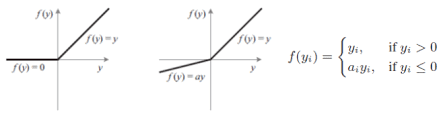

Here a(sub i) is a trainable parameter which could be trained by backpropagation. When a(sub i) = 0 it becomes relu and when it is a very small value it behaves like Leaky ReLu.
No. of extra parameters added due to PReLu is very small as it is equal to number of channels which is negligible when compared to total number of parameters.

Identity shortcuts can easily be applied when input and output are of same dimensions.
But when the dimensions are not same we consider 2 options:

1. Padding with zeroes
2. Using Projection Shortcuts


In [ ]:
initializer = tf.keras.initializers.he_normal()

**Implementing an Identity block**


In [ ]:
def identity_block(X, f, filters):
    #X: Input tensor of shape (batch_size, n_H, n_W, n_C)
    #filters: Number of filters in each Convolution
    #f: Filter size

    F1,F2,F3 = filters
    X_shortcut = X
    
    X = tf.keras.layers.Conv2D(F1, kernel_size = (1,1), strides = (1,1), padding = 'valid', kernel_initializer = initializer)(X)
    X = tf.keras.layers.BatchNormalization(epsilon = 0.001, axis = 3, momentum = 0.9 )(X)
    X = tf.keras.layers.PReLU()(X)
    
    X = tf.keras.layers.Conv2D(F2, kernel_size = (f,f), strides = (1,1), padding = 'same', kernel_initializer = initializer)(X)
    X = tf.keras.layers.BatchNormalization(epsilon = 0.001, axis = 3, momentum = 0.9)(X)
    X = tf.keras.layers.PReLU()(X)
    
    X = tf.keras.layers.Conv2D(F3, kernel_size = (1,1), strides = (1,1), padding = 'valid', kernel_initializer = initializer)(X)
    X = tf.keras.layers.BatchNormalization(epsilon = 0.001, axis = 3, momentum = 0.9)(X)
    
    X = tf.keras.layers.Add()([X, X_shortcut])
    X = tf.keras.layers.PReLU()(X)
    
    return X
    
    
    

**Implementing the Convolutional block**

In [ ]:
def convolutional_block(X, f, filters, s):
    #X: is a input tensor of shape (batch_size, n_H, n_W, n_C) where n_H is height of image, n_W is width of image and n_C is number of channels
    #filters: A list consisting of number of filters in each Convolution
    #f: Size of filter

    F1,F2,F3 = filters
    X_shortcut = X
    
    X = tf.keras.layers.Conv2D(F1, kernel_size = (1,1), strides = (s,s), padding = 'valid', kernel_initializer = initializer)(X)
    X = tf.keras.layers.BatchNormalization(epsilon = 0.001, axis = 3, momentum = 0.9 )(X)                                         #epsilon and momentum are according to original paper
    X = tf.keras.layers.PReLU()(X)
    
    X = tf.keras.layers.Conv2D(F2, kernel_size = (f,f), strides = (1,1), padding = 'same', kernel_initializer = initializer)(X)
    X = tf.keras.layers.BatchNormalization(epsilon = 0.001, axis = 3, momentum = 0.9)(X)
    X = tf.keras.layers.PReLU()(X)
    
    X = tf.keras.layers.Conv2D(F3, kernel_size = (1,1), strides = (1,1), padding = 'valid', kernel_initializer = initializer)(X)
    X = tf.keras.layers.BatchNormalization(epsilon = 0.001, axis = 3, momentum = 0.9)(X)
    
    X_shortcut = tf.keras.layers.Conv2D(F3, kernel_size = (1,1), strides = (s,s), padding = 'valid', kernel_initializer = initializer)(X_shortcut)
    X_shortcut = tf.keras.layers.BatchNormalization(epsilon = 0.001, axis = 3, momentum = 0.9)(X)
    
    X = tf.keras.layers.Add()([X, X_shortcut])
    X = tf.keras.layers.PReLU()(X)
    
    return X

**Building ResNet50**

In [ ]:
def ResNet50(input_shape = (224, 224, 3), classes = 3):
    #input_shape: Shape of the images of the dataset
    #classes: Number of classes which will be equal to number of units in the last layer

    X_input = tf.keras.Input(input_shape)

    X = tf.keras.layers.ZeroPadding2D((3, 3))(X_input)
    
    X = tf.keras.layers.Conv2D(64, (7, 7), strides = (2, 2), kernel_initializer = initializer)(X)
    X = tf.keras.layers.BatchNormalization(axis = 3)(X)
    X = tf.keras.layers.PReLU()(X)
    X = tf.keras.layers.MaxPooling2D((3, 3), strides=(2, 2))(X)

    X = convolutional_block(X, f = 3, filters = [64, 64, 256], s = 1)
    X = identity_block(X, 3, [64, 64, 256])
    X = identity_block(X, 3, [64, 64, 256])


    X = convolutional_block(X, f = 3, filters = [128, 128, 512], s = 2)
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])


    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], s = 2)
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])

    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], s = 2)
    X = identity_block(X, 3, [512, 512, 2048])
    X = identity_block(X, 3, [512, 512, 2048])

    X = tf.keras.layers.AveragePooling2D(pool_size=(2,2))(X)
    

    X = tf.keras.layers.Flatten()(X)
    X = tf.keras.layers.Dense(classes, activation='softmax', kernel_initializer = 'glorot_uniform')(X)
    
    
    # Create model
    model = tf.keras.Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [ ]:
model = ResNet50(input_shape = (224, 224, 3), classes = 3)

In [ ]:
#Running this cell will result in showing up parameters, shape of image in various layers

model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 64) 9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 112, 112, 64) 256         conv2d[0][0]                     
___________________________________________________________________________________________

In [ ]:
sgd_optimizer = tf.keras.optimizers.SGD(learning_rate = 0.001)

In [ ]:
#We use Adams optimization method to make the things faster. In original peper SGD optimization method is used

model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
#Callback for early stopping when desired accuracy is met

class AccCallbck(tf.keras.callbacks.Callback):
  def on_epoch_end(self,epoch,logs = {}):
    if(logs.get('val_accuracy')>=0.99):
      print('Desired Accuracy reached')
      self.model.stop_training = True

callbacks = AccCallbck()

In [ ]:
#steps_per_epoch = floor(Number of training images / batch_size)
#validation_steps = floor(Number of validation images / batch_size)

history1 = model.fit(train_generation, epochs = 50, steps_per_epoch = 110, validation_data = valid_generation, verbose = 1, validation_steps = 42) 

Epoch 1/50
110/110 [==============================] - 147s 1s/step - loss: 2.3335 - accuracy: 0.3494 - val_loss: 1.0874 - val_accuracy: 0.3355
Epoch 2/50
110/110 [==============================] - 146s 1s/step - loss: 1.1339 - accuracy: 0.3974 - val_loss: 1.0934 - val_accuracy: 0.5028
Epoch 3/50
110/110 [==============================] - 146s 1s/step - loss: 0.9960 - accuracy: 0.5233 - val_loss: 1.0169 - val_accuracy: 0.5417
Epoch 4/50
110/110 [==============================] - 146s 1s/step - loss: 0.8253 - accuracy: 0.6280 - val_loss: 3.4787 - val_accuracy: 0.7802
Epoch 5/50
110/110 [==============================] - 146s 1s/step - loss: 0.7211 - accuracy: 0.6809 - val_loss: 3.0671 - val_accuracy: 0.8451
Epoch 6/50
110/110 [==============================] - 146s 1s/step - loss: 0.6542 - accuracy: 0.7158 - val_loss: 1.9560 - val_accuracy: 0.8432
Epoch 7/50
110/110 [==============================] - 146s 1s/step - loss: 0.5780 - accuracy: 0.7515 - val_loss: 0.8642 - val_accuracy: 0.7829

In [ ]:
#Saving the trained model into h5 format file

model4.save("rps_partial4.h5")

In [ ]:
import json
hist_df = pd.DataFrame(history3.history) 

# save to json:  
hist_json_file = 'history.json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

In [ ]:
model2 = tf.keras.models.load_model('/content/gdrive/My Drive/rps_partial.h5')

In [ ]:
history2 = model2.fit(train_generation, epochs = 50, steps_per_epoch = 110, validation_data = valid_generation, verbose = 1, validation_steps = 42)

Epoch 1/50
110/110 [==============================] - 153s 1s/step - loss: 0.2134 - accuracy: 0.9209 - val_loss: 0.6443 - val_accuracy: 0.7060
Epoch 2/50
110/110 [==============================] - 152s 1s/step - loss: 0.1874 - accuracy: 0.9290 - val_loss: 1.0511 - val_accuracy: 0.4399
Epoch 3/50
110/110 [==============================] - 151s 1s/step - loss: 0.1970 - accuracy: 0.9302 - val_loss: 1.0051 - val_accuracy: 0.4568
Epoch 4/50
110/110 [==============================] - 151s 1s/step - loss: 0.1789 - accuracy: 0.9331 - val_loss: 1.3423 - val_accuracy: 0.7648
Epoch 5/50
110/110 [==============================] - 151s 1s/step - loss: 0.1827 - accuracy: 0.9351 - val_loss: 1.1808 - val_accuracy: 0.9224
Epoch 6/50
110/110 [==============================] - 150s 1s/step - loss: 0.1855 - accuracy: 0.9311 - val_loss: 0.3276 - val_accuracy: 0.8873
Epoch 7/50
110/110 [==============================] - 150s 1s/step - loss: 0.1771 - accuracy: 0.9382 - val_loss: 0.1632 - val_accuracy: 0.9435

In [ ]:
model3 = tf.keras.models.load_model('/content/gdrive/My Drive/rps_partial2.h5')

In [ ]:
history3 = model3.fit(train_generation, epochs = 50, steps_per_epoch = 110, validation_data = valid_generation, verbose = 1, validation_steps = 42)

Epoch 1/50
110/110 [==============================] - 141s 1s/step - loss: 0.1955 - accuracy: 0.9287 - val_loss: 0.2084 - val_accuracy: 0.9054
Epoch 2/50
110/110 [==============================] - 139s 1s/step - loss: 0.1896 - accuracy: 0.9324 - val_loss: 0.8478 - val_accuracy: 0.8850
Epoch 3/50
110/110 [==============================] - 140s 1s/step - loss: 0.1852 - accuracy: 0.9309 - val_loss: 1.7556 - val_accuracy: 0.9205
Epoch 4/50
110/110 [==============================] - 140s 1s/step - loss: 0.1659 - accuracy: 0.9409 - val_loss: 0.6067 - val_accuracy: 0.7248
Epoch 5/50
110/110 [==============================] - 140s 1s/step - loss: 0.1902 - accuracy: 0.9305 - val_loss: 0.1123 - val_accuracy: 0.9544
Epoch 6/50
110/110 [==============================] - 140s 1s/step - loss: 0.1921 - accuracy: 0.9288 - val_loss: 0.2138 - val_accuracy: 0.9438
Epoch 7/50
110/110 [==============================] - 140s 1s/step - loss: 0.1726 - accuracy: 0.9349 - val_loss: 0.1541 - val_accuracy: 0.9469

In [ ]:
model4 = tf.keras.models.load_model('/content/gdrive/My Drive/rps.h5')

In [ ]:
import time
saved_model_path = "./{}.h5".format(int(time.time()))

model4.save(saved_model_path)

In [ ]:
!pip install tensorflowjs

     |████████████████████████████████| 61kB 1.8MB/s 
     |████████████████████████████████| 137.3MB 111kB/s 
     |████████████████████████████████| 92kB 10.1MB/s 
     |████████████████████████████████| 256kB 39.8MB/s 
  Created wheel for PyInquirer: filename=PyInquirer-1.0.3-cp36-none-any.whl size=32852 sha256=a80aa8c6eaee779ff97a11ca583d0a40919e7f9f71effd09b9cef24f012e639e
  Stored in directory: /root/.cache/pip/wheels/52/6c/b1/3e4b0e8daf42a92883c7641c0ea8ffb62e0490ebed2faa55ad
Successfully built PyInquirer
  Found existing installation: tensorflow-hub 0.9.0
    Uninstalling tensorflow-hub-0.9.0:
      Successfully uninstalled tensorflow-hub-0.9.0
  Found existing installation: prompt-toolkit 1.0.18
    Uninstalling prompt-toolkit-1.0.18:
      Successfully uninstalled prompt-toolkit-1.0.18


In [ ]:
!tensorflowjs_converter --input_format=keras {saved_model_path} ./json

In [ ]:
history4 = model4.fit(train_generation, epochs = 1, steps_per_epoch = 110, validation_data = valid_generation, verbose = 1, validation_steps = 42)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

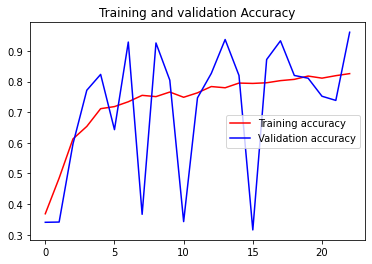

<Figure size 432x288 with 0 Axes>

In [ ]:
epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation Accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

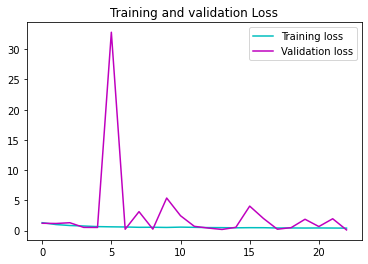

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(epochs, loss, 'c', label='Training loss')
plt.plot(epochs, val_loss, 'm', label='Validation loss')
plt.title('Training and validation Loss')
plt.legend(loc=0)
plt.figure()
plt.show()

# Converting model into JSON format
In this section we'll convert python tensorlow model into JSON format so that we can classify images on the web.

In [ ]:
!pip install tensorflowjs

     |████████████████████████████████| 61kB 4.8MB/s 
     |████████████████████████████████| 137.3MB 86kB/s 
     |████████████████████████████████| 92kB 13.0MB/s 
     |████████████████████████████████| 256kB 50.3MB/s 
  Created wheel for PyInquirer: filename=PyInquirer-1.0.3-cp36-none-any.whl size=32852 sha256=72779fe5a7686a3ef413bab2ee8ee6da6cb01c605d6695419e45f0cab791bfaa
  Stored in directory: /root/.cache/pip/wheels/52/6c/b1/3e4b0e8daf42a92883c7641c0ea8ffb62e0490ebed2faa55ad
Successfully built PyInquirer
  Found existing installation: tensorflow-hub 0.9.0
    Uninstalling tensorflow-hub-0.9.0:
      Successfully uninstalled tensorflow-hub-0.9.0
  Found existing installation: prompt-toolkit 1.0.18
    Uninstalling prompt-toolkit-1.0.18:
      Successfully uninstalled prompt-toolkit-1.0.18


In [ ]:
!pip install -U ipython

     |████████████████████████████████| 788kB 9.3MB/s 
     |████████████████████████████████| 358kB 23.1MB/s 
ERROR: pyinquirer 1.0.3 has requirement prompt-toolkit==1.0.14, but you'll have prompt-toolkit 3.0.7 which is incompatible.
ERROR: jupyter-console 5.2.0 has requirement prompt-toolkit<2.0.0,>=1.0.0, but you'll have prompt-toolkit 3.0.7 which is incompatible.
ERROR: google-colab 1.0.0 has requirement ipython~=5.5.0, but you'll have ipython 7.16.1 which is incompatible.
  Found existing installation: prompt-toolkit 1.0.14
    Uninstalling prompt-toolkit-1.0.14:
      Successfully uninstalled prompt-toolkit-1.0.14
  Found existing installation: ipython 5.5.0
    Uninstalling ipython-5.5.0:
      Successfully uninstalled ipython-5.5.0


In [ ]:
import numpy as np
import tensorflow as tf

print('\u2022 Using TensorFlow Version:', tf.__version__)

• Using TensorFlow Version: 2.3.1


In [ ]:
!tensorflowjs_converter \
          --input_format=tf_saved_model \
          /content/gdrive/My Drive/rps.h5 \
          /content/sample_data                

usage: TensorFlow.js model converters. [-h]
                                       [--input_format {tfjs_layers_model,keras,tf_saved_model,tf_frozen_model,tf_hub,keras_saved_model}]
                                       [--output_format {keras_saved_model,tfjs_graph_model,tfjs_layers_model,keras}]
                                       [--signature_name SIGNATURE_NAME]
                                       [--saved_model_tags SAVED_MODEL_TAGS]
                                       [--quantize_float16 [QUANTIZE_FLOAT16]]
                                       [--quantize_uint8 [QUANTIZE_UINT8]]
                                       [--quantize_uint16 [QUANTIZE_UINT16]]
                                       [--quantization_bytes {1,2}]
                                       [--split_weights_by_layer] [--version]
                                       [--skip_op_check]
                                       [--strip_debug_ops STRIP_DEBUG_OPS]
                                       [-